# Industrial Applications of Artificial Intelligence - Bias in Finance

### This notebook is part of the third hand-in regarding the secondary sector in the lecture Industrial Applications of AI by Niklas Sabel (Matr. no. 1599748)

Credit decisions, personal potential evaluation or support in judgements. Machine Learning algorithms are touching more and more areas of people's personal lives. However, this is not always benefitial. A sensation has been caused in 2016 by the publication of ProPublica about the software COMPAS (Correctional Offender Management Profiling for Alternative Sanctions) that should help in discovering the underlying risk of a criminal becoming a recidivist [[1]](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing). The authors found out that the algorithm is highly biased towards black people such that "black defendants are far more likely than white defendants to be incorrectly judged to be at a higher risk of recidivism" [[2]](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm). This impressively illustrates that if developers and designers are not careful, human bias is picked up by algorithms leading to highly unfair results. Therefore, one has to be especially cautious involving personal sensitive data, for example sex, political attitude or religious affiliation. In the following notebook, we explore the influence of sensitive information in the case of income prediction and investigate how sensitive data can influence the decision.

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.linear_model import LogisticRegression
import graphviz 
from xgboost import XGBClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Integer

## I. Data Exploration

The dataset can be found on kaggle unter the following [URL](https://www.kaggle.com/datasets/wenruliu/adult-income-dataset).  It was published by the Center for Machine Learning and Intelligent Systems of the University of California and the original dataset can be found under the following [link](http://www.cs.toronto.edu/~delve/data/adult/desc.html). The task is modelled as a binary classification to predicct if an individual's income excceds $50,000 based on data from the US Census Bureau. We want to explore if sensitive information does have an influence on the result and compare it to the case, when some information are discarded.
First of all, the dataset consists out of 48,842 entries containing 14 features and one target targets, which will be described in the following. We are not given a test set such that we have to create a split in the course of the work.
* age: Integer indicating the age of a person.
* workclass: Categorical variable indicating the employment status of a person.
* fnlwgt: Integer without further description. Nearly unique value per row, so might be kind of an identifier that may need to be discarded.
* education: Categorical variable indicating the highest degree of a person. 
* educational-num: Integer indicating the number of years spent on education.
* marital-status: Categorical variable indicating the marriage status.
* occupation: Categorical variable that indicates the employment type that a person has. 
* relationship: Categorical variable indicating the relationship status.
* race: Categorical variable indicating the race.
* gender: Binary variable that indicates wether a person is male or female.
* capital-gain: Integer indicating if a person has capital gains.
* capital-loss: Integer indicating if a person has capital losses.
* hours-per-week: Integer indicating how much hours a person works per week
* native-country: Categorical variable indicating the native-country of a person.
* income: Target. Binary variable that indicates wether a person has more than 50k income or not.

In [3]:
dir_path ='../../src/data/Abgabe_3/'

In [4]:
df = pd.read_csv(os.path.join(dir_path, "adult.csv"))
df.head(10)

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K
5,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K
6,29,?,227026,HS-grad,9,Never-married,?,Unmarried,Black,Male,0,0,40,United-States,<=50K
7,63,Self-emp-not-inc,104626,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,3103,0,32,United-States,>50K
8,24,Private,369667,Some-college,10,Never-married,Other-service,Unmarried,White,Female,0,0,40,United-States,<=50K
9,55,Private,104996,7th-8th,4,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,10,United-States,<=50K


In [5]:
# look at distribution
df.describe().transpose().applymap("{:.2f}".format)

,count,mean,std,min,25%,50%,75%,max
age,48842.00,38.64,13.71,17.00,28.00,37.00,48.00,90.00
fnlwgt,48842.00,189664.13,105604.03,12285.00,117550.50,178144.50,237642.00,1490400.00
educational-num,48842.00,10.08,2.57,1.00,9.00,10.00,12.00,16.00
capital-gain,48842.00,1079.07,7452.02,0.00,0.00,0.00,0.00,99999.00
capital-loss,48842.00,87.50,403.00,0.00,0.00,0.00,0.00,4356.00
hours-per-week,48842.00,40.42,12.39,1.00,40.00,40.00,45.00,99.00


We can clearly see that we have highly critical features inside our data: race and gender. On top of that the native-country and the workclass could have an influence as well. If an algorithm would be totally objective, neither of the variables would have any influence on the result. That means the distribution of income should not differ wether a person is male or female or he/she belongs to a different race. As a first step, we explore the distribution of those variables and investigate if there are already obvious conspicuities.

In [6]:
df.groupby('gender').income.value_counts()

gender  income
Female  <=50K     14423
        >50K       1769
Male    <=50K     22732
        >50K       9918
Name: income, dtype: int64

In [7]:
df.groupby('race').income.value_counts()

race                income
Amer-Indian-Eskimo  <=50K       415
                    >50K         55
Asian-Pac-Islander  <=50K      1110
                    >50K        409
Black               <=50K      4119
                    >50K        566
Other               <=50K       356
                    >50K         50
White               <=50K     31155
                    >50K      10607
Name: income, dtype: int64

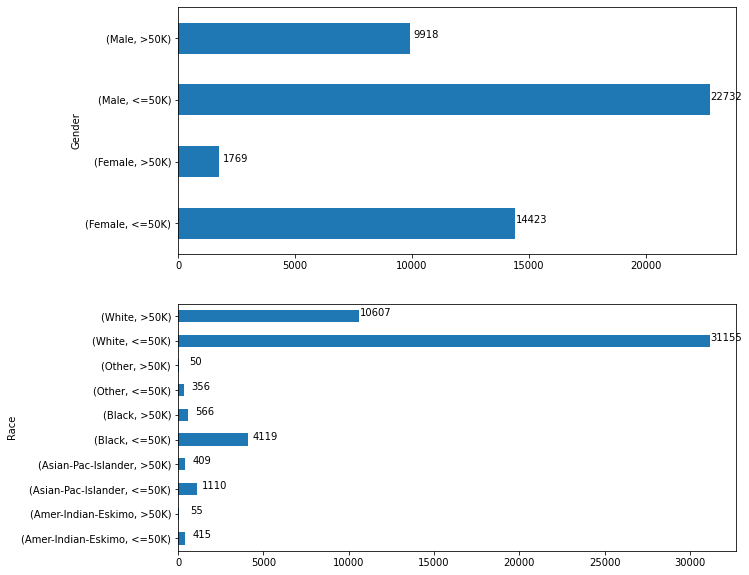

In [8]:
fig, (ax, ax2) = plt.subplots(2, 1,  figsize=(10,10))

df.groupby('gender').income.value_counts().plot(kind='barh',ax=ax)
ax.set_ylabel('Gender')
[ax.text(v+700, i, '{:}'.format(v), horizontalalignment='center') for i, v in enumerate(df.groupby('gender').income.value_counts())]
df.groupby('race').income.value_counts().plot(kind='barh',ax=ax2)
ax2.set_ylabel('Race')
[ax2.text(v+1000, i, '{:}'.format(v), horizontalalignment='center') for i, v in enumerate(df.groupby('race').income.value_counts())]
plt.show()

We can see that there is already a difference in the distribution towards women having less income than men. In the case of the race feature it is also obvious that the distributions differ a lot and white people having higher income, which looks a lot like bias. 

We gonna investigate right now, if the distributions of the numerical variables differ a lot for the gender and if that could be a possible explanation for the differences for the minority feature. For this reason, we split the dataset based on the feature and have a look at the other variables.

In [9]:
# Male
df_male = df[df['gender'] == 'Male']
#Female
df_female = df[df['gender'] == 'Female']

In [10]:
# look at distribution
df_male.describe().transpose().applymap("{:.2f}".format)

,count,mean,std,min,25%,50%,75%,max
age,32650.00,39.49,13.41,17.00,29.00,38.00,48.00,90.00
fnlwgt,32650.00,191727.02,106709.38,13492.00,117963.00,180138.00,241722.50,1490400.00
educational-num,32650.00,10.09,2.66,1.00,9.00,10.00,13.00,16.00
capital-gain,32650.00,1326.21,8367.78,0.00,0.00,0.00,0.00,99999.00
capital-loss,32650.00,100.41,430.22,0.00,0.00,0.00,0.00,3770.00
hours-per-week,32650.00,42.42,12.12,1.00,40.00,40.00,48.00,99.00


In [11]:
# look at distribution
df_female.describe().transpose().applymap("{:.2f}".format)

,count,mean,std,min,25%,50%,75%,max
age,16192.00,36.93,14.14,17.00,25.00,35.00,46.00,90.00
fnlwgt,16192.00,185504.47,103217.15,12285.00,116560.00,175572.00,228609.25,1484705.00
educational-num,16192.00,10.04,2.38,1.00,9.00,10.00,12.00,16.00
capital-gain,16192.00,580.73,5094.23,0.00,0.00,0.00,0.00,99999.00
capital-loss,16192.00,61.48,340.11,0.00,0.00,0.00,0.00,4356.00
hours-per-week,16192.00,36.40,11.95,1.00,30.00,40.00,40.00,99.00


We see that in most cases the statistical propties of the features do not differ by a lot. However, there are two features that stand out: age and hours-per-week. It seems that women in the dataset are overal younger and work less. This might be a possible explanation. In contrast, years of education are higher, which should indicate that women earn more.

Before we preprocess the dataset and execute predictions, we examine some of the feature distributions to get more insights into the data. 

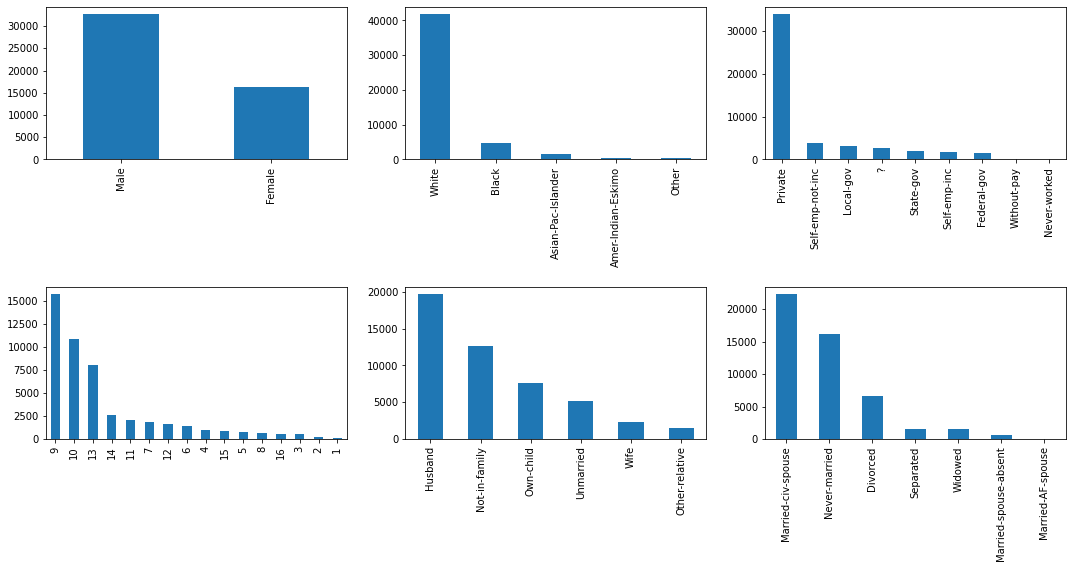

In [12]:
fig, axes = plt.subplots(2, 3,  figsize=(15,8))

#list of features to show
features = ['gender','race','workclass','educational-num','relationship','marital-status']

for i in range(2):
    for j in range(3):
        df[features[3*i+j]].value_counts().plot(kind='bar', ax = axes[i,j])
fig.tight_layout(h_pad=2, w_pad=2)
plt.show()

We can already see that we have a lot more male than female persons within the dataset and that the race distribution is clearly skewed in favor of whites, which could be problematic in the remaining analysis. On top of that, it is also noticeable that the majority of people in the study work in the private sector.
Most of people have 9 years of school education, which is equivalent to a high school graduation. Furthermore, it is evident that wh have far more people pursuing higher education than stopping before nine years. Regarding relationship and marital-status, it seems that most people are married or have never-married. We also see that relationship and marital-status might be somehow redundant, because there is a clear overlap. Therefore, we investigate the correlations between all the features in the course of the work.

We have already seen that the educational level and hours-per-week differ between male and females. We want to further investigate the relations and compare them to each other for sex and race. We normalize the values for better comparison, because the distribution is skewed.

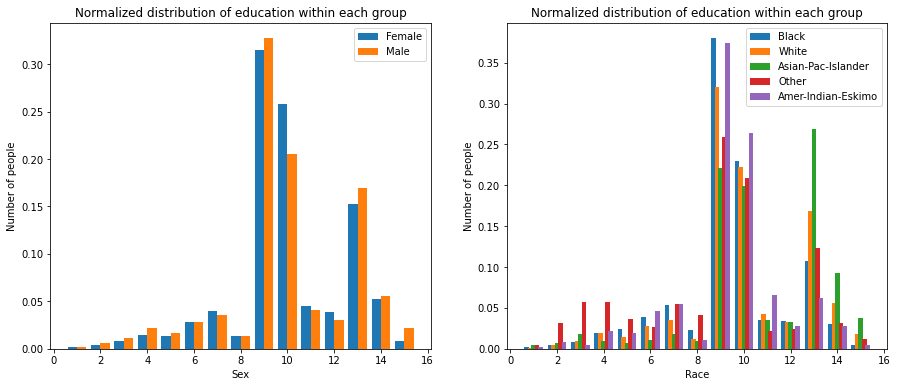

In [13]:
fig, (ax, ax2) = plt.subplots(1,2 ,  figsize=(15,6))

#plot for gender
X_axis = np.arange(len(df['educational-num'].unique()))
  
ax.bar(X_axis - 0.2, df[df['gender']=='Female'].groupby('gender')['educational-num'].value_counts().sort_index().shift(1)/len(df[df['gender']=='Female']), 0.4, label = 'Female')
ax.bar(X_axis + 0.2, df[df['gender']=='Male'].groupby('gender')['educational-num'].value_counts().sort_index().shift(1)/len(df[df['gender']=='Male']), 0.4, label = 'Male')
  
ax.set_xlabel("Sex")
ax.set_ylabel("Number of people")
ax.set_title("Normalized distribution of education within each group")
ax.legend()


#plot for race
X_axis = np.arange(len(df['educational-num'].unique()))
  
ax2.bar(X_axis - 0.3, df[df['race']=='Black'].groupby('race')['educational-num'].value_counts().sort_index().shift(1)/len(df[df['race']=='Black']), 0.2, label = 'Black')
ax2.bar(X_axis - 0.15, df[df['race']=='White'].groupby('race')['educational-num'].value_counts().sort_index().shift(1)/len(df[df['race']=='White']), 0.2, label = 'White')
ax2.bar(X_axis , df[df['race']=='Asian-Pac-Islander'].groupby('race')['educational-num'].value_counts().sort_index().shift(1)/len(df[df['race']=='Asian-Pac-Islander']), 0.2, label = 'Asian-Pac-Islander')
ax2.bar(X_axis + 0.15, df[df['race']=='Other'].groupby('race')['educational-num'].value_counts().sort_index().shift(1)/len(df[df['race']=='Other']), 0.2, label = 'Other')
ax2.bar(X_axis + 0.3, df[df['race']=='Amer-Indian-Eskimo'].groupby('race')['educational-num'].value_counts().sort_index().shift(1)/len(df[df['race']=='Amer-Indian-Eskimo']), 0.2, label = 'Amer-Indian-Eskimo')
  
ax2.set_xlabel("Race")
ax2.set_ylabel("Number of people")
ax2.set_title("Normalized distribution of education within each group")
ax2.legend()

plt.show()

We can see that there is a small tendency for women to have a higher percentage share completing higher education (e.g., a college: 10-12 years). However, the tendency shifts again, when it comes to doctoral degress (>12 years), where the share of man is higher again in percentage.
Based on the race there is a clear tendency that Asian-American pursue higher degrees, even doctoral dignities. For the other groups it seems that the main percentage of people having nine years of education, with some exceptions, e.g., Whites having a clear edge in percentage in >=13 years of education over the other groups outside Asian-American. Based on the educational-data, we can see that there might be problematic cases of having different distributions, especially for the races. However, we have already seen that women earn less than men, which cannot be based on the number of years of training.

In the following, we investigate how good an algorithm is able to predict that and if the distributions may further change due to bias.

# II. Preprocessing

Before we start with our preprocessing, we investigate the feature fnlwgt, because we noticed that it seems to be pretty unique and could therefore be useless.

In [14]:
len(df)

48842

In [15]:
df.fnlwgt.nunique()

28523

In [16]:
df[df.fnlwgt==151910]

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
44479,23,Private,151910,Bachelors,13,Never-married,Machine-op-inspct,Own-child,White,Female,0,1719,40,United-States,<=50K
48839,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K


We see that more than half of the entries have unique labels in the fnlwgt feature and if two entries have the same, they do not seem to be related. It is for this reason that we discard the feature as it does not offer any generalization improvement. 

In [17]:
df.drop(columns=['fnlwgt'],inplace =True)

In [18]:
df.head(5)

,age,workclass,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


Before we use an algorithm on the data, we gonna preprocess the features for better usage. In a first step, we check the set for missing values and afterwards round all the numerical features on two decimal places.

In [19]:
df.isna().sum()

age                0
workclass          0
education          0
educational-num    0
marital-status     0
occupation         0
relationship       0
race               0
gender             0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income             0
dtype: int64

We can see that in the whole set are no missing values. But is seems like in the dataset missing values are encoded as '?', because the publishers of the dataset state that there are around 7% missing values in the data. 

In [20]:
df[df.eq("?").any(1)]

,age,workclass,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
4,18,?,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K
6,29,?,HS-grad,9,Never-married,?,Unmarried,Black,Male,0,0,40,United-States,<=50K
13,58,?,HS-grad,9,Married-civ-spouse,?,Husband,White,Male,0,0,35,United-States,<=50K
19,40,Private,Doctorate,16,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,45,?,>50K
22,72,?,7th-8th,4,Divorced,?,Not-in-family,White,Female,0,0,6,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48811,35,?,Bachelors,13,Married-civ-spouse,?,Wife,White,Female,0,0,55,United-States,>50K
48812,30,?,Bachelors,13,Never-married,?,Not-in-family,Asian-Pac-Islander,Female,0,0,99,United-States,<=50K
48820,71,?,Doctorate,16,Married-civ-spouse,?,Husband,White,Male,0,0,10,United-States,>50K
48822,41,?,HS-grad,9,Separated,?,Not-in-family,Black,Female,0,0,32,United-States,<=50K


In [21]:
for col in df.columns:
    print(f'Feature {col} has {len(df[df[col]=="?"])} missing values')

Feature age has 0 missing values
Feature workclass has 2799 missing values
Feature education has 0 missing values
Feature educational-num has 0 missing values
Feature marital-status has 0 missing values
Feature occupation has 2809 missing values
Feature relationship has 0 missing values
Feature race has 0 missing values
Feature gender has 0 missing values
Feature capital-gain has 0 missing values
Feature capital-loss has 0 missing values
Feature hours-per-week has 0 missing values
Feature native-country has 857 missing values
Feature income has 0 missing values


The dataset contains 3,620 out of 48,842 rows (7.4%) with a least one question mark. We see that only workclass, occupation and native-country have missing values. We also know that workclass and occupation have a clear overlap and if someone does not offer his occupation than we do not get the workclass. First, we have a look at the correlations and see if we can fill features up based on other features. For this reason, we one-hot-encode the categorical features with the exception of the target.

In [22]:
df_ohe = pd.get_dummies(df, columns=["workclass", "education","marital-status","occupation","relationship","race","native-country","gender"])

In [23]:
corrMatrix=df_ohe.corr()
df_corr = corrMatrix[['workclass_?', 'occupation_?','native-country_?']]

In [24]:
df_corr[(abs(df_corr['workclass_?'])>=0.5) | (abs(df_corr['occupation_?'])>=0.5)|(abs(df_corr['native-country_?'])>=0.5)]

,workclass_?,occupation_?,native-country_?
workclass_?,1.000000,0.998110,-0.002088
occupation_?,0.998110,1.000000,-0.002202
native-country_?,-0.002088,-0.002202,1.000000


It seems that the correlations do not offer a lot of value to us, outside the occupation-workclass relationship. However, in most cases both values are missing. Therefore, we will update those values where one is given and the other one not. Since every imputation is not really better than guessing at the moment, we do not fill up the question marks yet and keep them, because they could provide usefull information. In our further work, we might investigate if discarding them completely or imputation, e.g., by median offers better results.

In [25]:
df[((df['workclass']=='?')&(df['occupation']!='?'))|((df['workclass']!='?')&(df['occupation']=='?'))]

,age,workclass,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
8785,17,Never-worked,11th,7,Never-married,?,Own-child,Black,Female,0,0,20,United-States,<=50K
11607,20,Never-worked,HS-grad,9,Married-spouse-absent,?,Other-relative,White,Male,0,0,35,United-States,<=50K
13898,18,Never-worked,11th,7,Never-married,?,Own-child,White,Male,0,0,35,United-States,<=50K
21642,18,Never-worked,10th,6,Never-married,?,Own-child,White,Male,0,0,40,United-States,<=50K
27126,23,Never-worked,7th-8th,4,Divorced,?,Not-in-family,White,Male,0,0,35,United-States,<=50K
31053,17,Never-worked,10th,6,Never-married,?,Own-child,White,Male,0,0,30,United-States,<=50K
36618,18,Never-worked,11th,7,Never-married,?,Own-child,White,Female,0,0,10,United-States,<=50K
39513,20,Never-worked,Some-college,10,Never-married,?,Own-child,Black,Male,0,0,40,United-States,<=50K
48585,30,Never-worked,HS-grad,9,Married-civ-spouse,?,Wife,Black,Female,0,0,40,United-States,<=50K
48595,18,Never-worked,Some-college,10,Never-married,?,Own-child,White,Male,0,0,4,United-States,<=50K


We see that in all cases, where an occupation is missing that person has never worked before, which explaines the question mark. We have a short look on other cases with workclass equals never-worked and see if imputing those values would make sense.

In [26]:
df[df['workclass']=='Never-worked']

,age,workclass,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
8785,17,Never-worked,11th,7,Never-married,?,Own-child,Black,Female,0,0,20,United-States,<=50K
11607,20,Never-worked,HS-grad,9,Married-spouse-absent,?,Other-relative,White,Male,0,0,35,United-States,<=50K
13898,18,Never-worked,11th,7,Never-married,?,Own-child,White,Male,0,0,35,United-States,<=50K
21642,18,Never-worked,10th,6,Never-married,?,Own-child,White,Male,0,0,40,United-States,<=50K
27126,23,Never-worked,7th-8th,4,Divorced,?,Not-in-family,White,Male,0,0,35,United-States,<=50K
31053,17,Never-worked,10th,6,Never-married,?,Own-child,White,Male,0,0,30,United-States,<=50K
36618,18,Never-worked,11th,7,Never-married,?,Own-child,White,Female,0,0,10,United-States,<=50K
39513,20,Never-worked,Some-college,10,Never-married,?,Own-child,Black,Male,0,0,40,United-States,<=50K
48585,30,Never-worked,HS-grad,9,Married-civ-spouse,?,Wife,Black,Female,0,0,40,United-States,<=50K
48595,18,Never-worked,Some-college,10,Never-married,?,Own-child,White,Male,0,0,4,United-States,<=50K


It seems, that there are no further cases and the question mark actually delivers information. Since there are more question marks in the occupation column, we will distinguish the never-workers by imputing no occupation instead of the question mark

In [27]:
df.loc[(df['workclass']=='Never-worked'), 'occupation'] = 'No occupation'

In [28]:
df[df['workclass']=='Never-worked']

,age,workclass,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
8785,17,Never-worked,11th,7,Never-married,No occupation,Own-child,Black,Female,0,0,20,United-States,<=50K
11607,20,Never-worked,HS-grad,9,Married-spouse-absent,No occupation,Other-relative,White,Male,0,0,35,United-States,<=50K
13898,18,Never-worked,11th,7,Never-married,No occupation,Own-child,White,Male,0,0,35,United-States,<=50K
21642,18,Never-worked,10th,6,Never-married,No occupation,Own-child,White,Male,0,0,40,United-States,<=50K
27126,23,Never-worked,7th-8th,4,Divorced,No occupation,Not-in-family,White,Male,0,0,35,United-States,<=50K
31053,17,Never-worked,10th,6,Never-married,No occupation,Own-child,White,Male,0,0,30,United-States,<=50K
36618,18,Never-worked,11th,7,Never-married,No occupation,Own-child,White,Female,0,0,10,United-States,<=50K
39513,20,Never-worked,Some-college,10,Never-married,No occupation,Own-child,Black,Male,0,0,40,United-States,<=50K
48585,30,Never-worked,HS-grad,9,Married-civ-spouse,No occupation,Wife,Black,Female,0,0,40,United-States,<=50K
48595,18,Never-worked,Some-college,10,Never-married,No occupation,Own-child,White,Male,0,0,4,United-States,<=50K


Furthermore, we encode all the categorical variables. The binary target variable and the binary variable for gender are encoded with 1 for true and 0 for false, while the remaining categorical variables are one-hot-encoded.

In [29]:
cleanup_nums = {"gender": {'Female': 1, 'Male': 0},
                "income": {'>50K': 1, '<=50K': 0}}
df_preprocessed = df.replace(cleanup_nums)
df_preprocessed.head()

,age,workclass,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,11th,7,Never-married,Machine-op-inspct,Own-child,Black,0,0,0,40,United-States,0
1,38,Private,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,0,0,0,50,United-States,0
2,28,Local-gov,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,0,0,0,40,United-States,1
3,44,Private,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,0,7688,0,40,United-States,1
4,18,?,Some-college,10,Never-married,?,Own-child,White,1,0,0,30,United-States,0


In [30]:
df_preprocessed = pd.get_dummies(df_preprocessed, columns=["workclass", "education","marital-status","occupation","relationship","race","native-country"])

In [31]:
df_preprocessed.head()

,age,educational-num,gender,capital-gain,capital-loss,hours-per-week,income,workclass_?,workclass_Federal-gov,workclass_Local-gov,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,25,7,0,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,38,9,0,0,0,50,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,28,12,0,0,0,40,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,44,10,0,7688,0,40,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,18,10,1,0,0,30,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


To not always copy and paste those steps in further processing, we will define a function preprocessing.

In [32]:
def preprocessing(df:pd.DataFrame, cleanup_nums: dict, categ:list) -> pd.DataFrame:
    """
    Function preprocess the dataset
    :param df: general dataframe
    :param cleanup_nums: dictionary of binary categorical columns to encode
    :param categ: list of categorical columns to one-hot-encode
    :return: preprocessed dataframe
    """

    df = df.replace(cleanup_nums)
    
    df = pd.get_dummies(df, columns=categ)
    # To avoid later processing problems, we rename the feature "educational_num" into "training_num"
    df.rename(columns = {'educational-num':'training-num'}, inplace = True )

    return df

In [263]:
df_preprocessed = preprocessing(df,{"gender": {'Female': 1, 'Male': 0}, "income": {'>50K': 1, '<=50K': 0}}, ["workclass", "education","marital-status","occupation","relationship","race","native-country"])

In [264]:
df_preprocessed

,age,training-num,gender,capital-gain,capital-loss,hours-per-week,income,workclass_?,workclass_Federal-gov,workclass_Local-gov,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,25,7,0,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,38,9,0,0,0,50,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,28,12,0,0,0,40,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,44,10,0,7688,0,40,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,18,10,1,0,0,30,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27,12,1,0,0,38,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
48838,40,9,0,0,0,40,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
48839,58,9,1,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
48840,22,9,0,0,0,20,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


Since we are not given a test set, we create a train-validation-test split to check the hypothesis on in a next step.

# III. Train-Validation-Test-Split

We split therefore split our given data into 60% train, 20% val and 20% test. Before we do that, we will have a short look on the distribution of our target to check for an imbalanced set.

<AxesSubplot:>

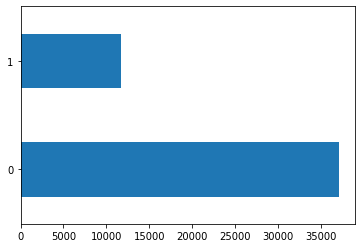

In [265]:
df_preprocessed['income'].value_counts().plot(kind ='barh')

To avoid later processing problems, we rename the feature "educational_num" into "training_num".

In [266]:
df_preprocessed

,age,training-num,gender,capital-gain,capital-loss,hours-per-week,income,workclass_?,workclass_Federal-gov,workclass_Local-gov,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,25,7,0,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,38,9,0,0,0,50,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,28,12,0,0,0,40,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,44,10,0,7688,0,40,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,18,10,1,0,0,30,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27,12,1,0,0,38,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
48838,40,9,0,0,0,40,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
48839,58,9,1,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
48840,22,9,0,0,0,20,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


We can clearly see that we have an imbalanced dataset with the majority of people earning less than 50k and therefore need to make sure to include all classes in our splitted sets via stratified sampling. The imbalance is also an indicator to use the f1-score as metric for our further downstream task instead of the accuracy, as accuracy would deliver a good result for not predicting the minor class at all. We will also keep the test set completely out of all steps except the last predicition to see how the algorithms perform on the test set.

In [267]:
# first split up in train+val and test
data_train_val, data_test, target_train_val, target_test = train_test_split(df_preprocessed.drop(columns=['income']), df_preprocessed['income'], test_size=0.2, random_state=42, stratify=df_preprocessed['income'])

In [268]:
#  split up train+val in train and val
data_train, data_val, target_train, target_val = train_test_split(data_train_val, target_train_val, test_size=0.2, random_state=42, stratify=target_train_val)

We will now have a look at the values in our different sets to check wether the distribution of the target is nearly the same.

In [269]:
# define values for plots
x = ['>50k','<=50k']
y_train = target_train.value_counts().to_list()
y_val = target_val.value_counts().to_list()
y_test = target_test.value_counts().to_list()

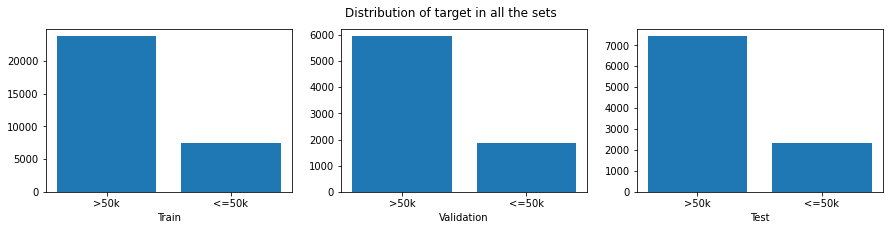

In [270]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,  figsize=(15,3))
fig.suptitle('Distribution of target in all the sets')
ax1.bar(x, y_train)
ax1.set_xlabel('Train')
ax2.bar(x, y_val)
ax2.set_xlabel('Validation')
ax3.bar(x, y_test)
ax3.set_xlabel('Test')
plt.show()

We can clearly see that the distribution is nearly the same for all our sets. As we generated the train-test-validation split in the previous step, we now want to scale the data as described earlier. This is for the reason, that different scales might actually distort our algorithm a lot due to big differences in the scales. For scaling, we use the StandardScaler from the sklearn package. It should be noted that we only fit the scaler on our training data and use only the transformation on the validation and testing part, because we do not want to include information about validation and test that could already help the algorithm (data leakage).

In [271]:
# define standard scaler
scaler = StandardScaler()
# features to scale
numerical_features = ['age','training-num', 'capital-gain','capital-loss','hours-per-week' ]
# transform data
data_train[numerical_features] = scaler.fit_transform(data_train[numerical_features])
data_val[numerical_features] = scaler.transform(data_val[numerical_features])
data_test[numerical_features] = scaler.transform(data_test[numerical_features])

In [272]:
data_train.head(5)

,age,training-num,gender,capital-gain,capital-loss,hours-per-week,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
32707,1.260788,-1.196134,0,-0.144436,-0.219322,-0.042541,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
34860,-0.049988,1.132320,1,-0.144436,-0.219322,-0.445174,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
32860,-1.506406,-0.808058,1,-0.144436,-0.219322,-1.653073,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
39091,-0.996659,-0.419983,0,-0.144436,-0.219322,2.373257,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
17608,0.969505,-0.419983,1,-0.144436,-0.219322,-0.042541,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [273]:
data_val.head(5)

,age,training-num,gender,capital-gain,capital-loss,hours-per-week,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
2190,-0.414092,-0.031907,0,-0.144436,-0.219322,1.567991,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
37436,-0.195630,0.744244,0,-0.144436,3.879509,0.360092,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
18121,-1.142301,-0.031907,0,-0.144436,-0.219322,0.279566,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5554,-0.705376,-0.031907,1,-0.144436,-0.219322,-0.042541,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14601,-1.069480,1.132320,0,-0.144436,-0.219322,-1.653073,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


In [274]:
data_test.head(5)

,age,training-num,gender,capital-gain,capital-loss,hours-per-week,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
40342,1.115147,-0.419983,1,-0.144436,-0.219322,-0.042541,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
47680,-0.778197,-0.419983,0,-0.144436,-0.219322,-1.653073,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
524,1.042326,-0.031907,0,-0.144436,-0.219322,0.762725,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
8508,1.406430,-0.419983,0,0.287581,-0.219322,-1.975179,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
31692,0.605400,0.744244,0,-0.144436,-0.219322,-0.042541,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


# IV. First algorithm and possible bias

We use a classic decision tree classifier for the testing purposes, as we can directly see which features have the highest influence on our results by plotting the tree. We first define a function to train the model that can be reused.

In [275]:
def model_training(x_train:pd.DataFrame, y_train:pd.DataFrame, x_val:pd.DataFrame, y_val:pd.DataFrame, model):
    """
    Function to train a model
    :param x_train: dataframe of features for training
    :param y_train: target dataframe for training
    :param x_val: dataframe of features for validation
    :param y_val: target dataframe for validation
    :param model: model class that should be fitted
    :return: trained model
    """
    model_fit = model
    model_fit.fit(x_train, y_train)
    prediction = model_fit.predict(x_val)
    acc = accuracy_score(y_val,prediction) 
    f1= f1_score(y_val,prediction, average = 'macro') 
    print("The Accuracy on the validation set: {:.4f}".format(acc))
    print("The F1-Score on the validation set: {:.4f}".format(f1))
    print('Confusion Matrix : \n' + str(confusion_matrix(y_val,prediction)))

    return model_fit, prediction

In [276]:
dt,prediction = model_training(data_train, target_train, data_val, target_val, DecisionTreeClassifier())

The Accuracy on the validation set: 0.8251
The F1-Score on the validation set: 0.7579
Confusion Matrix : 
[[5282  663]
 [ 704 1166]]


In [277]:
#feature importance  for race and gender
# get importance
importance = dt.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    if data_train.columns[i].split("_")[0] in ('race','gender'):
        print(F'Feature: {data_train.columns[i]}, Score: %.5f' % (v))

Feature: gender, Score: 0.00799
Feature: race_Amer-Indian-Eskimo, Score: 0.00155
Feature: race_Asian-Pac-Islander, Score: 0.00331
Feature: race_Black, Score: 0.00554
Feature: race_Other, Score: 0.00077
Feature: race_White, Score: 0.00686


We see that the race and the gender both have influence, although it is not completely high and may be overshadowed by the other variables. However, since it has an influence the results might be prone to bias due to sensitive information.

In the next step, we concatenate the validation set, the target and the prediction to see if we can see any anomalies in the false negatives based on gender and race. If there are some that may be a hint for bias in the model. In a first step, we to revert the one-hot-encoding for better understandability.

In [278]:
def revert_ohe(df, prefix_sep="_"):
    # get columns to revert based on the seperator
    col_revert = {
        item.split(prefix_sep)[0]: (prefix_sep in item) for item in df.columns
    }
    #list of final dataframe input
    series_list = []
    for col, needs_to_collapse in col_revert.items():
        if needs_to_collapse:
        # revert ohe per column and append it
            undummified = (
                df.filter(like=col)
                .idxmax(axis=1)
                .apply(lambda x: x.split(prefix_sep, maxsplit=1)[1])
                .rename(col)
            )
            series_list.append(undummified)
        else:
            # if column does not need to be reverted, just append it
            series_list.append(df[col])
    undummified_df = pd.concat(series_list, axis=1)
    return undummified_df

In [279]:
df_comparison = revert_ohe(data_val)

In [280]:
df_comparison.head(5)

,age,training-num,gender,capital-gain,capital-loss,hours-per-week,workclass,education,marital-status,occupation,relationship,race,native-country
2190,-0.414092,-0.031907,0,-0.144436,-0.219322,1.567991,Private,Some-college,Separated,Craft-repair,Own-child,White,United-States
37436,-0.195630,0.744244,0,-0.144436,3.879509,0.360092,Private,Assoc-acdm,Never-married,Prof-specialty,Not-in-family,White,United-States
18121,-1.142301,-0.031907,0,-0.144436,-0.219322,0.279566,Private,Some-college,Never-married,Craft-repair,Not-in-family,White,United-States
5554,-0.705376,-0.031907,1,-0.144436,-0.219322,-0.042541,Private,Some-college,Never-married,Adm-clerical,Not-in-family,White,Guatemala
14601,-1.069480,1.132320,0,-0.144436,-0.219322,-1.653073,Local-gov,Bachelors,Never-married,Transport-moving,Own-child,White,United-States


In [281]:
#double check if reverting was succesful
df[(df.index==2190)|(df.index==37436)|(df.index==18121)|(df.index==5554)|(df.index==14601)]

,age,workclass,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
2190,33,Private,Some-college,10,Separated,Craft-repair,Own-child,White,Male,0,0,60,United-States,<=50K
5554,29,Private,Some-college,10,Never-married,Adm-clerical,Not-in-family,White,Female,0,0,40,Guatemala,<=50K
14601,24,Local-gov,Bachelors,13,Never-married,Transport-moving,Own-child,White,Male,0,0,20,United-States,<=50K
18121,23,Private,Some-college,10,Never-married,Craft-repair,Not-in-family,White,Male,0,0,44,United-States,<=50K
37436,36,Private,Assoc-acdm,12,Never-married,Prof-specialty,Not-in-family,White,Male,0,1669,45,United-States,<=50K


In [282]:
# concate test set, target and final prediction for further use
df_comparison = pd.concat([df_comparison.reset_index(), target_val.reset_index(drop=True),pd.Series(prediction),], axis=1).set_index('index')
df_comparison.rename(columns={0 :'Prediction'}, inplace=True )
# on top of that we inverse transform the numerical columns and change them to integer again
numerical_features = ['age','training-num', 'capital-gain','capital-loss','hours-per-week' ]
df_comparison[numerical_features] = scaler.inverse_transform(df_comparison[numerical_features])
df_comparison[numerical_features] = df_comparison[numerical_features].astype(int)

In [283]:
df_comparison.head()

,age,training-num,gender,capital-gain,capital-loss,hours-per-week,workclass,education,marital-status,occupation,relationship,race,native-country,income,Prediction
index,,,,,,,,,,,,,,,
2190,33,10,0,0,0,60,Private,Some-college,Separated,Craft-repair,Own-child,White,United-States,0,0
37436,36,12,0,0,1669,45,Private,Assoc-acdm,Never-married,Prof-specialty,Not-in-family,White,United-States,0,0
18121,23,10,0,0,0,44,Private,Some-college,Never-married,Craft-repair,Not-in-family,White,United-States,0,0
5554,29,10,1,0,0,40,Private,Some-college,Never-married,Adm-clerical,Not-in-family,White,Guatemala,0,0
14601,24,13,0,0,0,20,Local-gov,Bachelors,Never-married,Transport-moving,Own-child,White,United-States,0,0


We filter on the different values of the sensitive features race and gender to get an overview if the algorithm is distorted.

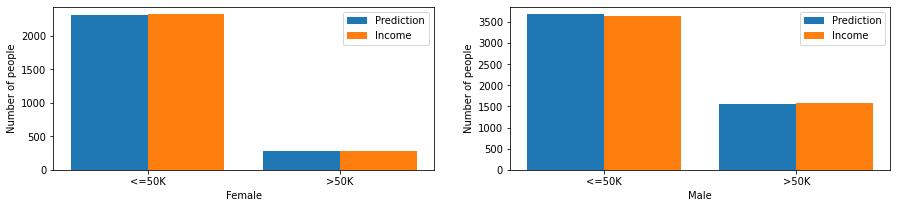

In [284]:
#compare amount of predictions and income
# rename labels into interpretable text
df2 = df_comparison.replace({"Prediction": { 1:'>50K', 0:'<=50K'}, "income": { 1:'>50K', 0:'<=50K'},"gender":{1:"Female",0:"Male"}})
fig, (ax, ax2) = plt.subplots(1,2 ,  figsize=(15,3))

#plot for gender
X_axis = np.arange(len(df2['Prediction'].unique()))
for axes in [ax,ax2]:
    if axes == ax:
        sex="Female"
    else: 
        sex="Male"
    axes.bar(X_axis - 0.2, df2[df2['gender']==sex].groupby('gender')['Prediction'].value_counts(), 0.4, label = 'Prediction')
    axes.bar(X_axis + 0.2, df2[df2['gender']==sex].groupby('gender')['income'].value_counts(), 0.4, label = 'Income')
    axes.set_xticks(X_axis,df2['Prediction'].unique())
    axes.set_xlabel(sex)
    axes.set_ylabel("Number of people")
    axes.legend()

The model does not seem to biased based on the gender feature, as their is no real big difference in the predictions and the labels per class. Therefore, there is not real tendency to predict more false positives per class, which means no bias in that direction.

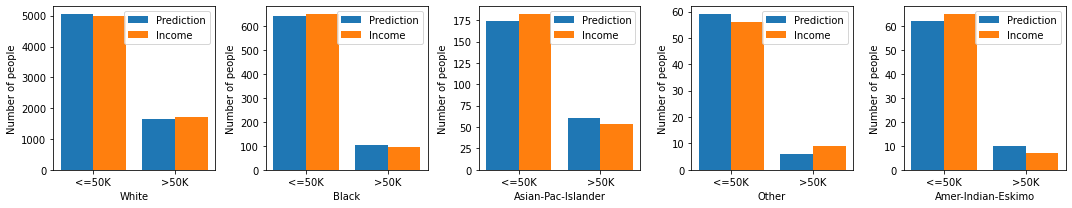

In [285]:
fig, axes = plt.subplots(1,5 ,  figsize=(15,3))

#plot for gender
X_axis = np.arange(len(df2['Prediction'].unique()))
race_list = df2['race'].unique().tolist()
count = 0
for ax in axes:
    race = race_list[count]
    ax.bar(X_axis - 0.2, df2[df2['race']==race].groupby('race')['Prediction'].value_counts(), 0.4, label = 'Prediction')
    ax.bar(X_axis + 0.2, df2[df2['race']==race].groupby('race')['income'].value_counts(), 0.4, label = 'Income')
    ax.set_xticks(X_axis,df2['Prediction'].unique())
    ax.set_xlabel(race)
    ax.set_ylabel("Number of people")
    ax.legend()
    count += 1
fig.tight_layout()

In [286]:
df_comparison.groupby('race')['income','Prediction'].value_counts()

race                income  Prediction
Amer-Indian-Eskimo  0       0               60
                            1                5
                    1       1                5
                            0                2
Asian-Pac-Islander  0       0              153
                    1       1               32
                    0       1               29
                    1       0               21
Black               0       0              606
                    1       1               60
                    0       1               45
                    1       0               36
Other               0       0               55
                    1       1                5
                            0                4
                    0       1                1
White               0       0             4408
                    1       1             1064
                            0              641
                    0       1              583
dtype: int64

On the contrary, for the race feature, there seems to be some bias involved. We can clearly see that for Amer-Indian-Eskimo, Asian-Pac-Islander and Black persons themodel is more likely to predict a higher income although that is not the case, while for Other and White people, it is more likely to predict less income. This shows that there is some small bias against those two groups. Unfortunately, we do not know, which people fall under the Other category. However, we see that the sample is not really big for most groups. So, this could be by chance as well and if we would have more samples, it would balance out (law of large numbers) .

# V. Reiterate and discard race feature

In the following section, we discard the race feature and train the same setting again to have a look if this bias was introduced due to the feature or not. We gonna check if the distribution above are still the same if we train the model without the feature.

In [287]:
df_preprocessed = df.drop(columns=['race'])
#use the defined functions for preprocessing
df_preprocessed = preprocessing(df_preprocessed,{"gender": {'Female': 1, 'Male': 0}, "income": {'>50K': 1, '<=50K': 0}}, ["workclass", "education","marital-status","occupation","relationship","native-country"])

In [288]:
# first split up in train+val and test
data_train_val, data_test, target_train_val, target_test = train_test_split(df_preprocessed.drop(columns=['income']), df_preprocessed['income'], test_size=0.2, random_state=42, stratify=df_preprocessed['income'])

#  split up train+val in train and val
data_train, data_val, target_train, target_val = train_test_split(data_train_val, target_train_val, test_size=0.2, random_state=42, stratify=target_train_val)

In [289]:
# define standard scaler as above
scaler = StandardScaler()
# features to scale
numerical_features = ['age','training-num', 'capital-gain','capital-loss','hours-per-week' ]
# transform data
data_train[numerical_features] = scaler.fit_transform(data_train[numerical_features])
data_val[numerical_features] = scaler.transform(data_val[numerical_features])
data_test[numerical_features] = scaler.transform(data_test[numerical_features])

In [290]:
#use the defined functions for training the model
dt,prediction = model_training(data_train, target_train, data_val, target_val, DecisionTreeClassifier())

The Accuracy on the validation set: 0.8247
The F1-Score on the validation set: 0.7580
Confusion Matrix : 
[[5274  671]
 [ 699 1171]]


Comparing to the results above, we already see that there is an improvement. But we need to be careful, because we do not use CV. So, this could be due to randomness as well.

In [291]:
#use the defined functions for revert the ohe 
df_comparison = revert_ohe(data_val)

In [292]:
# concate test set, target and final prediction for further use
df_comparison = pd.concat([df_comparison.reset_index(), target_val.reset_index(drop=True),pd.Series(prediction),], axis=1).set_index('index')
df_comparison.rename(columns={0 :'Prediction'}, inplace=True )
# on top of that we inverse transform the numerical columns and change them to integer again
numerical_features = ['age','training-num', 'capital-gain','capital-loss','hours-per-week' ]
df_comparison[numerical_features] = scaler.inverse_transform(df_comparison[numerical_features])
df_comparison[numerical_features] = df_comparison[numerical_features].astype(int)

To get again the distribution for the race feature, we join the original table based on the index.

In [293]:
df_comparison = pd.merge(df_comparison, df['race'], left_index=True, right_index=True)

In [294]:
df_comparison.head(5)

,age,training-num,gender,capital-gain,capital-loss,hours-per-week,workclass,education,marital-status,occupation,relationship,native-country,income,Prediction,race
2190,33,10,0,0,0,60,Private,Some-college,Separated,Craft-repair,Own-child,United-States,0,0,White
37436,36,12,0,0,1669,45,Private,Assoc-acdm,Never-married,Prof-specialty,Not-in-family,United-States,0,0,White
18121,23,10,0,0,0,44,Private,Some-college,Never-married,Craft-repair,Not-in-family,United-States,0,0,White
5554,29,10,1,0,0,40,Private,Some-college,Never-married,Adm-clerical,Not-in-family,Guatemala,0,0,White
14601,24,13,0,0,0,20,Local-gov,Bachelors,Never-married,Transport-moving,Own-child,United-States,0,0,White


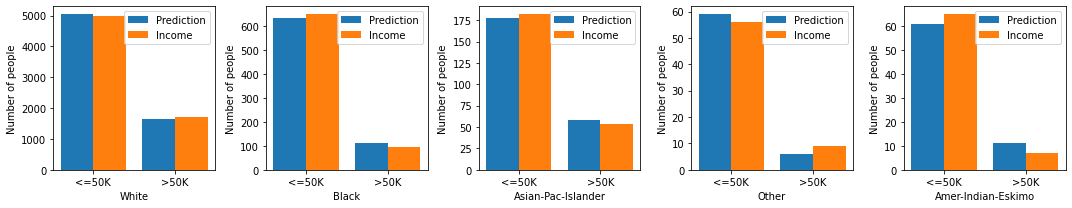

In [295]:
#compare amount of predictions and income
# rename labels into interpretable text
df2 = df_comparison.replace({"Prediction": { 1:'>50K', 0:'<=50K'}, "income": { 1:'>50K', 0:'<=50K'}})
fig, axes = plt.subplots(1,5 ,  figsize=(15,3))

#plot for gender
X_axis = np.arange(len(df2['Prediction'].unique()))
race_list = df2['race'].unique().tolist()
count = 0
for ax in axes:
    race = race_list[count]
    ax.bar(X_axis - 0.2, df2[df2['race']==race].groupby('race')['Prediction'].value_counts(), 0.4, label = 'Prediction')
    ax.bar(X_axis + 0.2, df2[df2['race']==race].groupby('race')['income'].value_counts(), 0.4, label = 'Income')
    ax.set_xticks(X_axis,df2['Prediction'].unique())
    ax.set_xlabel(race)
    ax.set_ylabel("Number of people")
    ax.legend()
    count += 1
fig.tight_layout()

In [296]:
df_comparison.groupby('race')['income','Prediction'].value_counts()

race                income  Prediction
Amer-Indian-Eskimo  0       0               60
                    1       1                6
                    0       1                5
                    1       0                1
Asian-Pac-Islander  0       0              158
                    1       1               34
                    0       1               24
                    1       0               19
Black               0       0              601
                    1       1               64
                    0       1               50
                    1       0               32
Other               0       0               55
                    1       1                5
                            0                4
                    0       1                1
White               0       0             4400
                    1       1             1062
                            0              643
                    0       1              591
dtype: int64

After discarding the feature, we get less false negatives (less income predicted, although it is high) for White (600 to 579), Black (36 to 34) and Asian-Pac-Islander (22 to 18) people, while the other results stay the same. However, as the amount of data is that small for some groups, we cannot really distinguish that this happens by chance or if there is bias inside the model. But it seems that discarding the race feature benefits the model and since it is a highly critical feature, it seems appropriate to do that.

# VI. Biased Train-Test split

In the following part of the notebook, we show another problem how bias could be introduced when we are not careful. We split the whole dataset again, but this time not based on a stratified split. We manipulate our split such that most of the cases where women have low income are in the training set and high income women are in the test set. We discard the gender feature and show that even without the feature, it might happen that the algorithm is prone to bias based on the training split.

We begin again by creating the preprocessed dataset and split up the set in train and test. However, this time we manipulate the dataset by filtering out the women with high income first (around 1,800 entries/4% of whole set), put them into the test set and then create the remaining split of 16% for the test data. This leads to a split of 80% train and 20% test data. We are not creating a validation set, since we are not gonna optimize anything based on this split

In [247]:
#use the defined functions for preprocessing
df_preprocessed = preprocessing(df,{"gender": {'Female': 1, 'Male': 0}, "income": {'>50K': 1, '<=50K': 0}}, ["workclass", "education","marital-status","occupation","relationship","native-country","race"])

In [248]:
df_preprocessed[(df_preprocessed['gender']==1)&(df_preprocessed['income']==1)]

,age,training-num,gender,capital-gain,capital-loss,hours-per-week,income,workclass_?,workclass_Federal-gov,workclass_Local-gov,...,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White
45,28,11,1,0,0,36,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
89,41,14,1,7688,0,10,1,1,0,0,...,0,0,1,0,0,0,0,0,0,1
92,33,14,1,5178,0,10,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
119,43,13,1,0,0,40,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
126,48,16,1,0,0,40,1,0,1,0,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48811,35,13,1,0,0,55,1,1,0,0,...,0,0,1,0,0,0,0,0,0,1
48817,34,13,1,0,0,55,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
48819,38,13,1,15020,0,45,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0
48826,39,12,1,0,0,20,1,0,0,1,...,0,0,1,0,0,0,0,0,0,1


In [249]:
df_woman_high = df_preprocessed[(df_preprocessed['gender']==1)&(df_preprocessed['income']==1)]

In [250]:
df_preprocessed_bias = df_preprocessed[~((df_preprocessed['gender']==1)&(df_preprocessed['income']==1))]

In [251]:
# first split up in train+val and test
data_train, data_test, target_train, target_test = train_test_split(df_preprocessed_bias.drop(columns=['income']), df_preprocessed_bias['income'], test_size=0.16, random_state=42, stratify=df_preprocessed_bias['income'])


In [252]:
data_test = pd.concat([data_test, df_woman_high.drop(columns=['income'])])
target_test = pd.concat([target_test, df_woman_high['income']])

We again train a scaler for the numeric features, but we drop the gender column in train and test first.

In [253]:
data_train.drop(columns=['gender'],inplace=True)
data_test.drop(columns=['gender'],inplace=True)

In [254]:
# define standard scaler as above
scaler = StandardScaler()
# features to scale
numerical_features = ['age','training-num', 'capital-gain','capital-loss','hours-per-week' ]
# transform data
data_train[numerical_features] = scaler.fit_transform(data_train[numerical_features])
data_test[numerical_features] = scaler.transform(data_test[numerical_features])

In [255]:
#use the defined functions for training the model
dt,prediction = model_training(data_train, target_train, data_test, target_test, DecisionTreeClassifier())

The Accuracy on the validation set: 0.7211
The F1-Score on the validation set: 0.6509
Confusion Matrix : 
[[5439  506]
 [2088 1268]]


In [256]:
#use the defined functions for revert the ohe 
df_comparison = revert_ohe(data_test)
# concate test set, target and final prediction for further use
df_comparison = pd.concat([df_comparison.reset_index(), target_test.reset_index(drop=True),pd.Series(prediction),], axis=1).set_index('index')
df_comparison.rename(columns={0 :'Prediction'}, inplace=True )
# on top of that we inverse transform the numerical columns and change them to integer again
numerical_features = ['age','training-num', 'capital-gain','capital-loss','hours-per-week' ]
df_comparison[numerical_features] = scaler.inverse_transform(df_comparison[numerical_features])
df_comparison[numerical_features] = df_comparison[numerical_features].astype(int)

To get again the distribution for the race feature, we join the original table based on the index.

In [257]:
df_comparison = pd.merge(df_comparison, df['gender'], left_index=True, right_index=True)

In [258]:
df_comparison.head(5)

,age,training-num,capital-gain,capital-loss,hours-per-week,workclass,education,marital-status,occupation,relationship,native-country,race,income,Prediction,gender
13182,21,6,0,0,40,Private,10th,Never-married,Craft-repair,Own-child,United-States,White,0,0,Male
35159,42,9,0,0,40,Private,HS-grad,Married-civ-spouse,Handlers-cleaners,Husband,United-States,White,1,0,Male
32068,41,9,0,1887,45,Private,HS-grad,Married-civ-spouse,Transport-moving,Husband,United-States,White,1,1,Male
21305,45,9,0,1672,40,Federal-gov,HS-grad,Married-civ-spouse,Adm-clerical,Husband,United-States,White,0,1,Male
47885,52,9,0,0,40,Private,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,United-States,White,1,0,Male


array([<AxesSubplot:title={'center':'Female'}>,
       <AxesSubplot:title={'center':'Male'}>], dtype=object)

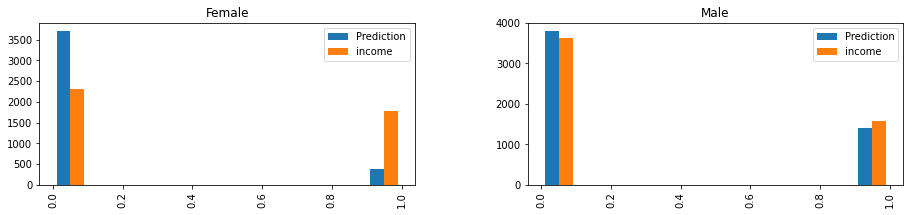

In [259]:
#compare amount of predictions and income
df_comparison.hist(column=['Prediction','income'],by=df_comparison['gender'],figsize=(15,3),legend=True)

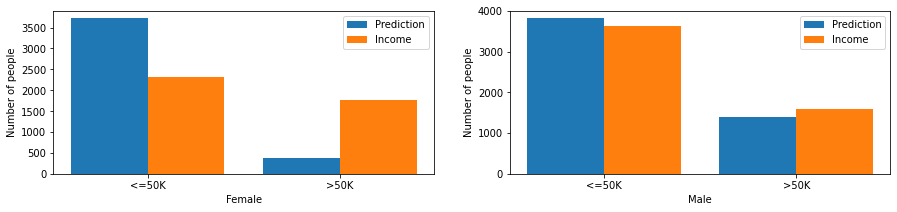

In [261]:
#compare amount of predictions and income
# rename labels into interpretable text
df2 = df_comparison.replace({"Prediction": { 1:'>50K', 0:'<=50K'}, "income": { 1:'>50K', 0:'<=50K'}})
fig, (ax, ax2) = plt.subplots(1,2 ,  figsize=(15,3))

#plot for gender
X_axis = np.arange(len(df2['Prediction'].unique()))
for axes in [ax,ax2]:
    if axes == ax:
        sex="Female"
    else: 
        sex="Male"
    axes.bar(X_axis - 0.2, df2[df2['gender']==sex].groupby('gender')['Prediction'].value_counts(), 0.4, label = 'Prediction')
    axes.bar(X_axis + 0.2, df2[df2['gender']==sex].groupby('gender')['income'].value_counts(), 0.4, label = 'Income')
    axes.set_xticks(X_axis,df2['Prediction'].unique())
    axes.set_xlabel(sex)
    axes.set_ylabel("Number of people")
    axes.legend()



In comparison, to our earlier results for gender, we can clearly see that we have a lot of more false negatives for women such that we predict the lower income class instead of the higher income class. This happens, because we excluded all high income women from the training set. Therefore, the model could not learn that women can have a high income. This shows that bias cannot only be introduced by features itself, but by a biased train-test split as well.

# VII. Model improvement

Unfortunately, we can not give a final answer about the question if bias is introduced or not based on the features itself, although there are signs that it is better to discard the race feature. However, how bias can be introduced by a bad train-test-split is quite clear and has to be taken into account. In the remaining work, we focus on improving the model by different feature selection methods and hyperparameter optimization. Thereby, we first try three other models, namelyLogistic Regression, XGBoost and RF to compare the results to our decision tree and see if they are already far better. As baselines, we gonna implement a random rate classifier that uses prior knowledge of class assignments in predicting the lass and the prior used decision tree.

In [80]:
df_preprocessed = df.drop(columns=['race'])
#use the defined functions for preprocessing
df_preprocessed = preprocessing(df_preprocessed,{"gender": {'Female': 1, 'Male': 0}, "income": {'>50K': 1, '<=50K': 0}}, ["workclass", "education","marital-status","occupation","relationship","native-country"])

In [81]:
# first split up in train+val and test
data_train_val, data_test, target_train_val, target_test = train_test_split(df_preprocessed.drop(columns=['income']), df_preprocessed['income'], test_size=0.2, random_state=42, stratify=df_preprocessed['income'])

#  split up train+val in train and val
data_train, data_val, target_train, target_val = train_test_split(data_train_val, target_train_val, test_size=0.2, random_state=42, stratify=target_train_val)

In [82]:
# define standard scaler as above
scaler = StandardScaler()
# features to scale
numerical_features = ['age','training-num', 'capital-gain','capital-loss','hours-per-week' ]
# transform data
data_train[numerical_features] = scaler.fit_transform(data_train[numerical_features])
data_val[numerical_features] = scaler.transform(data_val[numerical_features])
data_test[numerical_features] = scaler.transform(data_test[numerical_features])

### Baseline

In [83]:
# random rate classifier
# first get the probabilities of each class
prop_high_income = round(len(target_val[target_val==1])/len(target_val),3)
prop_low_income = round(len(target_val[target_val==0])/len(target_val),3)
print(f'Predicting higher income happens in {prop_high_income*100} % of cases')
print(f'Predicting lower income happens in {prop_low_income*100} % of cases')

Predicting higher income happens in 23.9 % of cases
Predicting lower income happens in 76.1 % of cases


In [84]:
#Create prediction vector
pred = np.random.choice([0, 1], size=len(target_val), p=[prop_low_income, prop_high_income])
acc = accuracy_score(target_val,pred) 
f1= f1_score(target_val,pred, average = 'macro') 
print("The Accuracy on the validation set: {:.4f}".format(acc))
print("The F1-Score on the validation set: {:.4f}".format(f1))
print('Confusion Matrix : \n' + str(confusion_matrix(target_val,pred)))

The Accuracy on the validation set: 0.6329
The F1-Score on the validation set: 0.4950
Confusion Matrix : 
[[4515 1430]
 [1439  431]]


In [85]:
#check the results for the decision tree
dt,prediction = model_training(data_train, target_train, data_val, target_val, DecisionTreeClassifier())

The Accuracy on the validation set: 0.8237
The F1-Score on the validation set: 0.7568
Confusion Matrix : 
[[5267  678]
 [ 700 1170]]


### More sophisticated Models

In [86]:
#check the results for logistic regression
dt,prediction = model_training(data_train, target_train, data_val, target_val, LogisticRegression())

The Accuracy on the validation set: 0.8535
The F1-Score on the validation set: 0.7847
Confusion Matrix : 
[[5544  401]
 [ 744 1126]]


In [87]:
#check the results for the decision tree
dt,prediction = model_training(data_train, target_train, data_val, target_val, RandomForestClassifier())

The Accuracy on the validation set: 0.8485
The F1-Score on the validation set: 0.7842
Confusion Matrix : 
[[5448  497]
 [ 687 1183]]


In [88]:
#check the results for the decision tree
dt,prediction = model_training(data_train, target_train, data_val, target_val, XGBClassifier(eval_metric='error'))

The Accuracy on the validation set: 0.8760
The F1-Score on the validation set: 0.8200
Confusion Matrix : 
[[5602  343]
 [ 626 1244]]


We already see that XGBoost has far better performances than the simple decision tree, logistic regression and random forest. Thus, we gonna focus on XGBoost for further optimization.

### Optimization XGBoost